# Part 2 - Live Tweet Analysis
In this notebook, I perform basically the same analysis as I did on the archived data in Notebook 2, except this time I do it with tweets from the past week.  In Notebook 2 we found that comparing a stock to its sector and industry did not add much value and so in this notebook I have not done that analysis.  I will say this several times but the findings in this and the next notebook should be taken with an enormous grain of salt because there are only 5 trading days of data.  This should merely be seen as a proof of concept and a first step to further exploration.

In [1]:
import pandas as pd
import datetime, time
import matplotlib.pyplot as plt
import pickle
from scipy import stats
pd.core.common.is_list_like=pd.api.types.is_list_like
import pandas_datareader as pdr
from textblob import TextBlob
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
vader=SentimentIntensityAnalyzer()
pd.core.common.is_list_like=pd.api.types.is_list_like
import pandas_datareader as pdr
pickle_in=open("df_api.pickle","rb")
df_api=pickle.load(pickle_in)
pickle_in=open("daily_api_returns.pickle","rb")
daily_api_returns=pickle.load(pickle_in)
pickle_in=open("all_api_tweets.pickle","rb")
all_api_tweets=pickle.load(pickle_in)

## Isolating by Relative Volume of Tweets
Here I isolate trades by the volume of tweets relative to the average volume of tweets for each individual stock.

Text(0.5, 1.0, 'Average Return Per Trade')

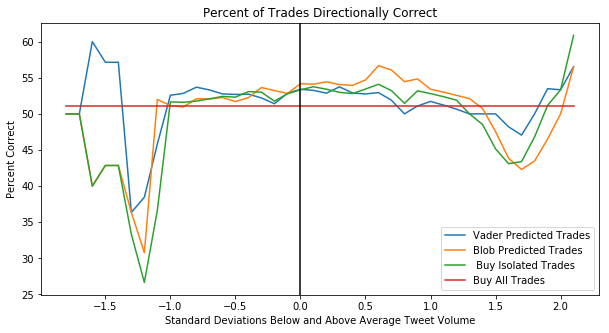

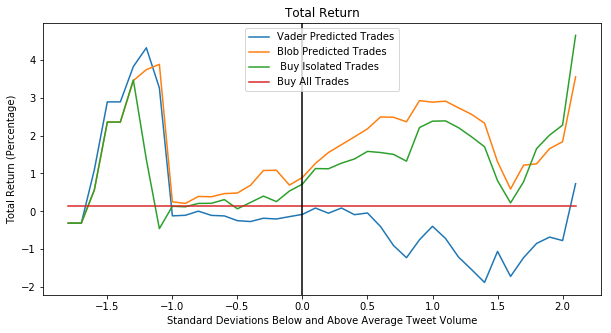

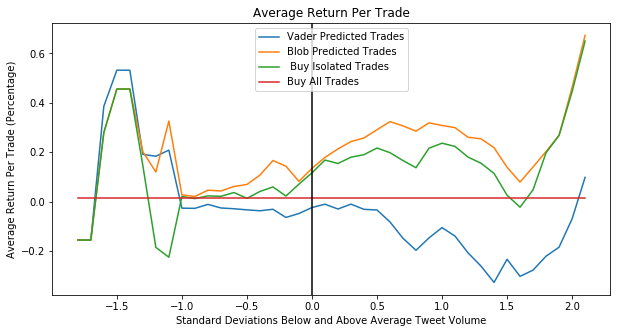

In [5]:
results=pd.DataFrame([])
for j in range(5,45):
    # This isolates the trades with relative tweet volume greater than the threshold into a data frame called "big"
    if j<13:
        big=df_api[df_api.num_stock_tweets<(df_api.stock_num_tweet_mean-(df_api.stock_num_tweet_std*((23-j)/10)))]
    else:
        big=df_api[df_api.num_stock_tweets>(df_api.stock_num_tweet_mean+(df_api.stock_num_tweet_std*((j-23)/10)))]
    big.reset_index(drop=True,inplace=True)
    min_sentiment=.0000001
    x_v_date=big.trade_date
    x_v=big.stock_weighted_vader
    x_b=big.stock_weighted_blob
    y=big.stock_move
    fails_v,fails_b=[],[]
    vader_trades=pd.DataFrame([])
    blob_trades=pd.DataFrame([])
    # This creates a dataframe of the Vader trades
    for i in range(len(x_v)):
        if (x_v[i]<-min_sentiment) & (y[i]>min_sentiment):
            vader_trades=vader_trades.append(pd.DataFrame({'date':x_v_date[i],'stock_move':-y[i]},index=[0]),ignore_index=True)
        elif (x_v[i]>min_sentiment) & (y[i]>min_sentiment):
            vader_trades=vader_trades.append(pd.DataFrame({'date':x_v_date[i],'stock_move':y[i]},index=[0]),ignore_index=True)
        elif (x_v[i]>min_sentiment) & (y[i]<-min_sentiment):
            vader_trades=vader_trades.append(pd.DataFrame({'date':x_v_date[i],'stock_move':y[i]},index=[0]),ignore_index=True)
        elif (x_v[i]<-min_sentiment) & (y[i]<-min_sentiment):
            vader_trades=vader_trades.append(pd.DataFrame({'date':x_v_date[i],'stock_move':-y[i]},index=[0]),ignore_index=True)
        else:
            fails_v.append(y[i]) 
    # This creates a dataframe of the Blob trades
    for i in range(len(x_b)):
        if (x_b[i]<-min_sentiment) & (y[i]>min_sentiment):
            blob_trades=blob_trades.append(pd.DataFrame({'date':x_v_date[i],'stock_move':-y[i]},index=[0]),ignore_index=True)
        elif (x_b[i]>min_sentiment) & (y[i]>min_sentiment):
            blob_trades=blob_trades.append(pd.DataFrame({'date':x_v_date[i],'stock_move':y[i]},index=[0]),ignore_index=True)
        elif (x_b[i]>min_sentiment) & (y[i]<-min_sentiment):
            blob_trades=blob_trades.append(pd.DataFrame({'date':x_v_date[i],'stock_move':y[i]},index=[0]),ignore_index=True)
        elif (x_b[i]<-min_sentiment) & (y[i]<-min_sentiment):
            blob_trades=blob_trades.append(pd.DataFrame({'date':x_v_date[i],'stock_move':-y[i]},index=[0]),ignore_index=True)
        else:
            fails_b.append(y[i]) 
    # This creates a dataframe for the real-world-return for Vader trades, hence "rwrv"
    rwrv=pd.DataFrame([])
    rwrv_days=big.trade_date.unique()
    for i in rwrv_days:
        isov=big[big.trade_date==i]
        vad=vader_trades[vader_trades.date==i]
        al_trades=df_api[df_api.trade_date==i]
        rwrv=rwrv.append(pd.DataFrame({'day':i,'vader':vad.stock_move.mean(),'iso_trades':isov.stock_move.mean(),
                                     'all_trades':al_trades.stock_move.mean(),
                                    'num_vader':len(vad),'num_all':len(al_trades)},index=[0]),ignore_index=True)  
    # This creates a dataframe for the real-world-return for Blob trades, hence "rwrb"
    rwrb=pd.DataFrame([])
    rwrb_days=big.trade_date.unique()
    for i in rwrb_days:
        isob=big[big.trade_date==i]
        blo=blob_trades[blob_trades.date==i]
        al_trades=df_api[df_api.trade_date==i]
        rwrb=rwrb.append(pd.DataFrame({'day':i,'blob':blo.stock_move.mean(),'iso_trades':isob.stock_move.mean(),
                                     'all_trades':al_trades.stock_move.mean(),
                                    'num_vader':len(blo),'num_all':len(al_trades)},index=[0]),ignore_index=True) 
    # This brings it all together
    results=results.append(pd.DataFrame({'min_tweets':(j-23)/10,'num_vader_trades':len(vader_trades),
                                         'num_blob_trades':len(blob_trades),
                                         'vader_pct_correct':vader_trades.stock_move.gt(0).sum()/len(vader_trades),
                                         'blob_pct_correct':blob_trades.stock_move.gt(0).sum()/len(blob_trades),
                                        'iso_pct_up':big.stock_move.gt(0).sum()/len(big),
                                         'all_pct_up':df_api.stock_move.gt(0).sum()/len(df_api),
                                        'total_vader_return':rwrv.vader.sum(),
                                         'total_blob_return':rwrb.blob.sum(),
                                         'total_iso_return':rwrv.iso_trades.sum(),
                                        'total_bh':rwrv.all_trades.sum(),
                                        'avg_vader_ret':vader_trades.stock_move.mean(),
                                         'avg_blob_ret':blob_trades.stock_move.mean(),
                                        'avg_iso_ret':big.stock_move.mean(),
                                        'avg_bh_ret':df_api.stock_move.mean()},index=[0]),ignore_index=True)
plt.figure(figsize=(10,5))
plt.plot(results.min_tweets,results.vader_pct_correct*100,label='Vader Predicted Trades')
plt.plot(results.min_tweets,results.blob_pct_correct*100,label='Blob Predicted Trades')
plt.plot(results.min_tweets,results.iso_pct_up*100,label=' Buy Isolated Trades')
plt.plot(results.min_tweets,results.all_pct_up*100,label='Buy All Trades')
plt.axvline(0,color='black')
plt.legend()
plt.xlabel('Standard Deviations Below and Above Average Tweet Volume')
plt.ylabel('Percent Correct')
plt.title('Percent of Trades Directionally Correct')
plt.figure(figsize=(10,5))
plt.plot(results.min_tweets,results.total_vader_return*100,label='Vader Predicted Trades')
plt.plot(results.min_tweets,results.total_blob_return*100,label='Blob Predicted Trades')
plt.plot(results.min_tweets,results.total_iso_return*100,label=' Buy Isolated Trades')
plt.plot([results.min_tweets[0],results.min_tweets[len(results)-1]],[results.total_bh[0]*100,results.total_bh[0]*100],label='Buy All Trades')
plt.axvline(0,color='black')
plt.legend()
plt.xlabel('Standard Deviations Below and Above Average Tweet Volume')
plt.ylabel("Total Return (Percentage)")
plt.title('Total Return')
# Note: the Buy All Trades line moves because it throws out days in which there was not sufficient tweeeting
plt.figure(figsize=(10,5))
plt.plot(results.min_tweets,results.avg_vader_ret*100,label='Vader Predicted Trades')
plt.plot(results.min_tweets,results.avg_blob_ret*100,label='Blob Predicted Trades')
plt.plot(results.min_tweets,results.avg_iso_ret*100,label=' Buy Isolated Trades')
plt.plot(results.min_tweets,results.avg_bh_ret*100,label='Buy All Trades')
plt.axvline(0,color='black')
plt.legend()
plt.xlabel('Standard Deviations Below and Above Average Tweet Volume')
plt.ylabel("Average Return Per Trade (Percentage)")
plt.title('Average Return Per Trade')

## Top Chart
The top chart shows that the isolated trades predict a higher percentage of trades correctly than the benchmark of predicting that every trade will go up within one standard deviation in both directions.  The results appear to be skewed by the small number of data points at both extremes. 
## Middle and Bottom Chart
The middle and bottom charts show that the TextBlob predicted trades generally increase in predictive ability as the relative tweet volume increases.  Interestingly, the Vader trades seem to perform quite poorly after having done well on the archived tweets.

# Isolating by Sentiment:

Text(0.5, 1.0, 'Average Return')

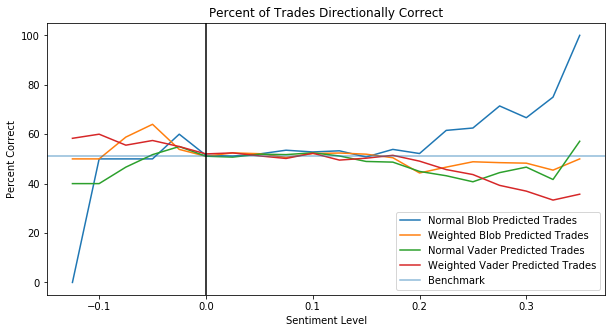

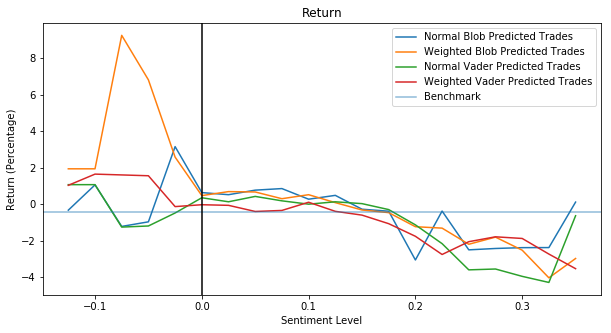

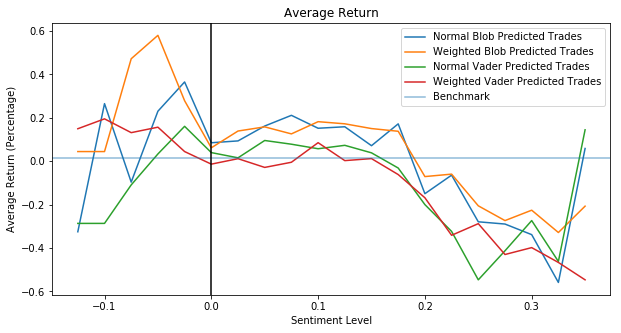

In [9]:
results=pd.DataFrame([])
for j in range(35,55):
    # This isolates the trades with an unweighted stock Vader score within the specified slice
    if j<40:
        bigvn=df_api[df_api.stock_vader<((j-40)/40)]
    else:
        bigvn=df_api[df_api.stock_vader>((j-40)/40)]
    bigvn.reset_index(drop=True,inplace=True)
    min_sentiment=.0000001
    x_vn_date=bigvn.trade_date
    x_vn=bigvn.stock_vader
    yvn=bigvn.stock_move
    vadern_trades=pd.DataFrame([])
    if len(bigvn)==0:
        vadern_trades=vadern_trades.append(pd.DataFrame({'date':0,'stock_move':0},index=[0]),ignore_index=True)
    else:
        None
    # This creates a dataframe of the unweighted Vader trades
    for i in range(len(x_vn)):
        if (x_vn[i]<-min_sentiment) & (yvn[i]>min_sentiment):
            vadern_trades=vadern_trades.append(pd.DataFrame({'date':x_vn_date[i],'stock_move':-yvn[i]},index=[0]),ignore_index=True)
        elif (x_vn[i]>min_sentiment) & (yvn[i]>min_sentiment):
            vadern_trades=vadern_trades.append(pd.DataFrame({'date':x_vn_date[i],'stock_move':yvn[i]},index=[0]),ignore_index=True)
        elif (x_vn[i]>min_sentiment) & (yvn[i]<-min_sentiment):
            vadern_trades=vadern_trades.append(pd.DataFrame({'date':x_vn_date[i],'stock_move':yvn[i]},index=[0]),ignore_index=True)
        elif (x_vn[i]<-min_sentiment) & (yvn[i]<-min_sentiment):
            vadern_trades=vadern_trades.append(pd.DataFrame({'date':x_vn_date[i],'stock_move':-yvn[i]},index=[0]),ignore_index=True)
        else:
            None
    rwrvn=pd.DataFrame([])
    rwrvn_days=bigvn.trade_date.unique()
    # This creates a dataframe for the real-world-return for unweighted Vader trades, hence "rwrvn"
    for i in rwrvn_days:
        isovn=bigvn[bigvn.trade_date==i]
        vadn=vadern_trades[vadern_trades.date==i]
        al_trades=df_api[df_api.trade_date==i]
        rwrvn=rwrvn.append(pd.DataFrame({'day':i,'vadern':vadn.stock_move.mean(),'iso_trades':isovn.stock_move.mean(),
                                     'all_trades':al_trades.stock_move.mean(),
                                    'num_vader':len(vadn),'num_all':len(al_trades)},index=[0]),ignore_index=True)
        
    # This isolates the trades with a weighted stock Vader score within the specified slice
    if j<40:
        bigvw=df_api[df_api.stock_weighted_vader<((j-40)/40)]
    else:
        bigvw=df_api[df_api.stock_weighted_vader>((j-40)/40)]
    bigvw.reset_index(drop=True,inplace=True)
    x_vw_date=bigvw.trade_date
    x_vw=bigvw.stock_weighted_vader
    yvw=bigvw.stock_move
    vaderw_trades=pd.DataFrame([])
    if len(bigvw)==0:
        vaderw_trades=vaderw_trades.append(pd.DataFrame({'date':0,'stock_move':0},index=[0]),ignore_index=True)
    else:
        None
    # This creates a dataframe of the unweighted Vader trades
    for i in range(len(x_vw)):
        if (x_vw[i]<-min_sentiment) & (yvw[i]>min_sentiment):
            vaderw_trades=vaderw_trades.append(pd.DataFrame({'date':x_vw_date[i],'stock_move':-yvw[i]},index=[0]),ignore_index=True)
        elif (x_vw[i]>min_sentiment) & (yvw[i]>min_sentiment):
            vaderw_trades=vaderw_trades.append(pd.DataFrame({'date':x_vw_date[i],'stock_move':yvw[i]},index=[0]),ignore_index=True)
        elif (x_vw[i]>min_sentiment) & (yvw[i]<-min_sentiment):
            vaderw_trades=vaderw_trades.append(pd.DataFrame({'date':x_vw_date[i],'stock_move':yvw[i]},index=[0]),ignore_index=True)
        elif (x_vw[i]<-min_sentiment) & (yvw[i]<-min_sentiment):
            vaderw_trades=vaderw_trades.append(pd.DataFrame({'date':x_vw_date[i],'stock_move':-yvw[i]},index=[0]),ignore_index=True)
        else:
            None
    rwrvw=pd.DataFrame([])
    rwrvw_days=bigvw.trade_date.unique()
    # This creates a dataframe for the real-world-return for unweighted Vader trades, hence "rwrvn"
    for i in rwrvw_days:
        isovw=bigvw[bigvw.trade_date==i]
        vadw=vaderw_trades[vaderw_trades.date==i]
        al_trades=df_api[df_api.trade_date==i]
        rwrvw=rwrvw.append(pd.DataFrame({'day':i,'vaderw':vadw.stock_move.mean(),'iso_trades':isovw.stock_move.mean(),
                                     'all_trades':al_trades.stock_move.mean(),
                                    'num_vader':len(vadw),'num_all':len(al_trades)},index=[0]),ignore_index=True)
            
        # This isolates the trades with an unweighted stock Blob score within the specified slice
    if j<40:
        bigbn=df_api[df_api.stock_blob<((j-40)/40)]
    else:
        bigbn=df_api[df_api.stock_blob>((j-40)/40)]
    bigbn.reset_index(drop=True,inplace=True)
    x_bn_date=bigbn.trade_date
    x_bn=bigbn.stock_vader
    ybn=bigbn.stock_move
    blobn_trades=pd.DataFrame([])
    if len(bigbn)==0:
        blobn_trades=blobn_trades.append(pd.DataFrame({'date':0,'stock_move':0},index=[0]),ignore_index=True)
    else:
        None
    # This creates a dataframe of the unweighted Vader trades
    for i in range(len(x_bn)):
        if (x_bn[i]<-min_sentiment) & (ybn[i]>min_sentiment):
            blobn_trades=blobn_trades.append(pd.DataFrame({'date':x_bn_date[i],'stock_move':-ybn[i]},index=[0]),ignore_index=True)
        elif (x_bn[i]>min_sentiment) & (ybn[i]>min_sentiment):
            blobn_trades=blobn_trades.append(pd.DataFrame({'date':x_bn_date[i],'stock_move':ybn[i]},index=[0]),ignore_index=True)
        elif (x_bn[i]>min_sentiment) & (ybn[i]<-min_sentiment):
            blobn_trades=blobn_trades.append(pd.DataFrame({'date':x_bn_date[i],'stock_move':ybn[i]},index=[0]),ignore_index=True)
        elif (x_bn[i]<-min_sentiment) & (ybn[i]<-min_sentiment):
            blobn_trades=blobn_trades.append(pd.DataFrame({'date':x_bn_date[i],'stock_move':-ybn[i]},index=[0]),ignore_index=True)
        else:
            None
    rwrbn=pd.DataFrame([])
    rwrbn_days=bigbn.trade_date.unique()
    # This creates a dataframe for the real-world-return for unweighted Vader trades, hence "rwrvn"
    for i in rwrbn_days:
        isobn=bigbn[bigbn.trade_date==i]
        blon=blobn_trades[blobn_trades.date==i]
        al_trades=df_api[df_api.trade_date==i]
        rwrbn=rwrbn.append(pd.DataFrame({'day':i,'blobn':blon.stock_move.mean(),'iso_trades':isobn.stock_move.mean(),
                                     'all_trades':al_trades.stock_move.mean(),
                                    'num_vader':len(blon),'num_all':len(al_trades)},index=[0]),ignore_index=True)
        
        # This isolates the trades with a weighted stock Blob score within the specified slice
    if j<40:
        bigbw=df_api[df_api.stock_weighted_blob<((j-40)/40)]
    else:
        bigbw=df_api[df_api.stock_weighted_blob>((j-40)/40)]
    bigbw.reset_index(drop=True,inplace=True)
    x_bw_date=bigbw.trade_date
    x_bw=bigbw.stock_vader
    ybw=bigbw.stock_move
    blobw_trades=pd.DataFrame([])
    if len(bigbw)==0:
        blobw_trades=blobw_trades.append(pd.DataFrame({'date':0,'stock_move':0},index=[0]),ignore_index=True)
    else:
        None
    # This creates a dataframe of the unweighted Vader trades
    for i in range(len(x_bw)):
        if (x_bw[i]<-min_sentiment) & (ybw[i]>min_sentiment):
            blobw_trades=blobw_trades.append(pd.DataFrame({'date':x_bw_date[i],'stock_move':-ybw[i]},index=[0]),ignore_index=True)
        elif (x_bw[i]>min_sentiment) & (ybw[i]>min_sentiment):
            blobw_trades=blobw_trades.append(pd.DataFrame({'date':x_bw_date[i],'stock_move':ybw[i]},index=[0]),ignore_index=True)
        elif (x_bw[i]>min_sentiment) & (ybw[i]<-min_sentiment):
            blobw_trades=blobw_trades.append(pd.DataFrame({'date':x_bw_date[i],'stock_move':ybw[i]},index=[0]),ignore_index=True)
        elif (x_bw[i]<-min_sentiment) & (ybw[i]<-min_sentiment):
            blobw_trades=blobw_trades.append(pd.DataFrame({'date':x_bw_date[i],'stock_move':-ybw[i]},index=[0]),ignore_index=True)
        else:
            None
    rwrbw=pd.DataFrame([])
    rwrbw_days=bigbw.trade_date.unique()
    # This creates a dataframe for the real-world-return for unweighted Vader trades, hence "rwrvn"
    for i in rwrbw_days:
        isobw=bigbw[bigbw.trade_date==i]
        blow=blobw_trades[blobw_trades.date==i]
        al_trades=df_api[df_api.trade_date==i]
        rwrbw=rwrbw.append(pd.DataFrame({'day':i,'blobw':blow.stock_move.mean(),'iso_trades':isobw.stock_move.mean(),
                                     'all_trades':al_trades.stock_move.mean(),
                                    'num_vader':len(blow),'num_all':len(al_trades)},index=[0]),ignore_index=True)
    
 
    # This brings it all together
    results=results.append(pd.DataFrame({'sentiment_slice':((j-40)/40),
                                         'vn_num':len(vadern_trades),
                                         'vw_num':len(vaderw_trades),
                                         'bn_num':len(blobn_trades),
                                         'bw_num':len(blobw_trades),
                                         'vn_pct_correct':vadern_trades.stock_move.gt(0).sum()/len(vadern_trades),
                                         'vw_pct_correct':vaderw_trades.stock_move.gt(0).sum()/len(vaderw_trades),
                                         'bn_pct_correct':blobn_trades.stock_move.gt(0).sum()/len(blobn_trades),
                                         'bw_pct_correct':blobw_trades.stock_move.gt(0).sum()/len(blobw_trades),
                                        'vn_iso_pct_up':bigvn.stock_move.gt(0).sum()/len(bigvn),
                                         'vw_iso_pct_up':bigvw.stock_move.gt(0).sum()/len(bigvw),
                                         'bn_iso_pct_up':bigbn.stock_move.gt(0).sum()/len(bigbn),
                                         'bw_iso_pct_up':bigbw.stock_move.gt(0).sum()/len(bigbw),
                                         'all_pct_up':df_api.stock_move.gt(0).sum()/len(df_api),
                                         'vn_return':rwrvn.vadern.sum(),
                                         'vw_return':rwrvw.vaderw.sum(),
                                         'bn_return':rwrbn.blobn.sum(),
                                         'bw_return':rwrbw.blobw.sum(),
                                         'iso_vn_return':rwrvn.iso_trades.sum(),
                                         'iso_vw_return':rwrvw.iso_trades.sum(),
                                         'iso_bn_return':rwrbn.iso_trades.sum(),
                                         'iso_bw_return':rwrbw.iso_trades.sum(),
                                         'total_bh':rwrv.all_trades.sum(),
                                        'avg_vn':vadern_trades.stock_move.mean(),
                                         'avg_vw':vaderw_trades.stock_move.mean(),
                                         'avg_bn':blobn_trades.stock_move.mean(),
                                         'avg_bw':blobw_trades.stock_move.mean(),
                                         'iso_vn_avg':bigvn.stock_move.mean(),
                                         'iso_vw_avg':bigvw.stock_move.mean(),
                                         'iso_bn_avg':bigbn.stock_move.mean(),
                                         'iso_bw_avg':bigbw.stock_move.mean(),
                                        'avg_bh_ret':df_api.stock_move.mean()},index=[0]),ignore_index=True)
bench_pct=results.all_pct_up[0]*100 # For easy use in later charts
bench_ret=results.total_bh[0]*100 # For easy use in later charts
bench_avg_ret=results.avg_bh_ret[0]*100 # For easy use in later charts
plt.figure(figsize=(10,5))
plt.plot(results.sentiment_slice,results.bn_pct_correct*100,label='Normal Blob Predicted Trades')
plt.plot(results.sentiment_slice,results.bw_pct_correct*100,label='Weighted Blob Predicted Trades')
plt.plot(results.sentiment_slice,results.vn_pct_correct*100,label='Normal Vader Predicted Trades')
plt.plot(results.sentiment_slice,results.vw_pct_correct*100,label='Weighted Vader Predicted Trades')
plt.axhline(bench_pct,label='Benchmark',alpha=.5)
plt.axvline(0,color='black')
plt.legend()
plt.xlabel('Sentiment Level')
plt.ylabel('Percent Correct')
plt.title('Percent of Trades Directionally Correct')
plt.figure(figsize=(10,5))
plt.plot(results.sentiment_slice,results.bn_return*100,label='Normal Blob Predicted Trades')
plt.plot(results.sentiment_slice,results.bw_return*100,label='Weighted Blob Predicted Trades')
plt.plot(results.sentiment_slice,results.vn_return*100,label='Normal Vader Predicted Trades')
plt.plot(results.sentiment_slice,results.vw_return*100,label='Weighted Vader Predicted Trades')
plt.axhline(bench_ret,label='Benchmark',alpha=.5)
plt.axvline(0,color='black')
plt.legend()
plt.xlabel('Sentiment Level')
plt.ylabel('Return (Percentage)')
plt.title('Return')
plt.figure(figsize=(10,5))
plt.plot(results.sentiment_slice,results.avg_bn*100,label='Normal Blob Predicted Trades')
plt.plot(results.sentiment_slice,results.avg_bw*100,label='Weighted Blob Predicted Trades')
plt.plot(results.sentiment_slice,results.avg_vn*100,label='Normal Vader Predicted Trades')
plt.plot(results.sentiment_slice,results.avg_vw*100,label='Weighted Vader Predicted Trades')
plt.axhline(bench_avg_ret,label='Benchmark',alpha=.5)
plt.axvline(0,color='black')
plt.legend()
plt.xlabel('Sentiment Level')
plt.ylabel('Average Return (Percentage)')
plt.title('Average Return')

## Top Chart
It appears that only the un-weighted TextBlob predicted trades outperformed the benchmark but only on sentiment scores above 0.2.

## Middle and Bottom Chart
All four scores seem to add at least some value for scores less than 0.2.  My guess is that because of the very limited amount of data, there is a single day that is skewing the results.

# Applying to Real World Trading:

Percent of Vader Trades Predicted Directionally Correct:  50.0 %
Percent of Blob Trades Predicted Directionally Correct:  47.54 %
Percent of All Trades that went Up:  51.08 %
Percent of High Tweet Volume Trades that went up:  45.16 %
Average Weighted Vader Return:  -0.234 %      StDev:  2.68 %
Average Weighted Blob Return:  0.139 %      StDev:  2.68 %
Average High Tweet Volume Buy and Hold Return:  0.03 %      StDev:  2.68 %
Average Return if all Trades are Bought:  0.02 %      StDev:  1.76 %


C:\Users\kylej\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


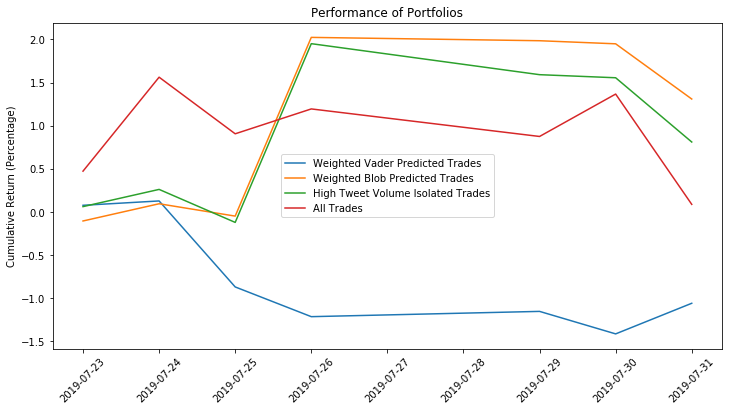

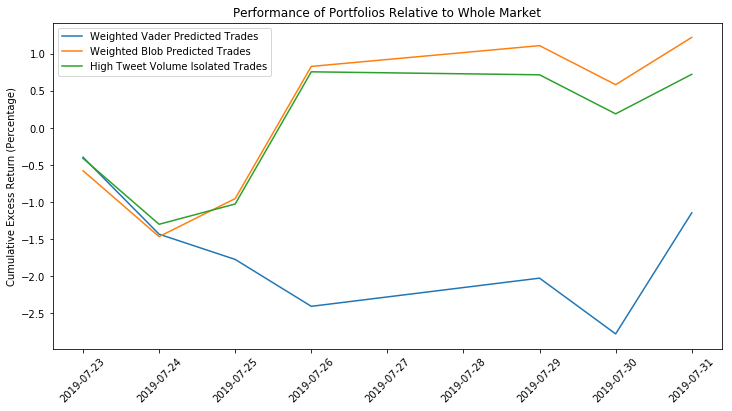

In [6]:
big=df_api[df_api.num_stock_tweets>(df_api.stock_num_tweet_mean+df_api.stock_num_tweet_std*1.5)]
big.reset_index(drop=True,inplace=True)
min_vader=.0000001
x_date=big.trade_date
x=big.stock_weighted_vader
y=big.stock_move
q1,q2,q3,q4,fails=[],[],[],[],[]
vader_trades=[]
vader_trades_df=pd.DataFrame([])
for i in range(len(x)):
    if (x[i]<-min_vader) & (y[i]>min_vader):
        q1.append(y[i])
        vader_trades.append(-y[i])
        vader_trades_df=vader_trades_df.append(pd.DataFrame({'date':x_date[i],'stock_move':-y[i]},index=[0]),ignore_index=True)
    elif (x[i]>min_vader) & (y[i]>min_vader):
        q2.append(y[i])
        vader_trades.append(y[i])
        vader_trades_df=vader_trades_df.append(pd.DataFrame({'date':x_date[i],'stock_move':y[i]},index=[0]),ignore_index=True)
    elif (x[i]>min_vader) & (y[i]<-min_vader):
        q3.append(y[i])
        vader_trades.append(y[i])
        vader_trades_df=vader_trades_df.append(pd.DataFrame({'date':x_date[i],'stock_move':y[i]},index=[0]),ignore_index=True)
    elif (x[i]<-min_vader) & (y[i]<-min_vader):
        q4.append(y[i])
        vader_trades.append(-y[i])
        vader_trades_df=vader_trades_df.append(pd.DataFrame({'date':x_date[i],'stock_move':-y[i]},index=[0]),ignore_index=True)
    else:
        fails.append(y[i])     
        
xb_date=big.trade_date
xb=big.stock_weighted_blob
yb=big.stock_move
b1,b2,b3,b4,fails=[],[],[],[],[]
blob_trades=[]
blob_trades_df=pd.DataFrame([])
for i in range(len(x)):
    if (xb[i]<-min_vader) & (yb[i]>min_vader):
        b1.append(yb[i])
        blob_trades.append(-yb[i])
        blob_trades_df=blob_trades_df.append(pd.DataFrame({'date':xb_date[i],'stock_move':-yb[i]},index=[0]),ignore_index=True)
    elif (xb[i]>min_vader) & (yb[i]>min_vader):
        b2.append(yb[i])
        blob_trades.append(yb[i])
        blob_trades_df=blob_trades_df.append(pd.DataFrame({'date':xb_date[i],'stock_move':yb[i]},index=[0]),ignore_index=True)
    elif (xb[i]>min_vader) & (yb[i]<-min_vader):
        b3.append(yb[i])
        blob_trades.append(yb[i])
        blob_trades_df=blob_trades_df.append(pd.DataFrame({'date':xb_date[i],'stock_move':yb[i]},index=[0]),ignore_index=True)
    elif (xb[i]<-min_vader) & (yb[i]<-min_vader):
        b4.append(y[i])
        blob_trades.append(-yb[i])
        blob_trades_df=blob_trades_df.append(pd.DataFrame({'date':xb_date[i],'stock_move':-yb[i]},index=[0]),ignore_index=True)
    else:
        fails.append(y[i])        
        
vader_total_accepted=len(q1)+len(q2)+len(q3)+len(q4)
blob_total_accepted=len(b1)+len(b2)+len(b3)+len(b4)
print('Percent of Vader Trades Predicted Directionally Correct: ',
      round((len(q2)+len(q4))/(len(q1)+len(q2)+len(q3)+len(q4))*100,2),'%')
print('Percent of Blob Trades Predicted Directionally Correct: ',
      round((len(b2)+len(b4))/(len(b1)+len(b2)+len(b3)+len(b4))*100,2),'%')
print('Percent of All Trades that went Up: ',round(df_api.stock_move.gt(0).sum()/len(df_api)*100,2),'%')
print('Percent of High Tweet Volume Trades that went up: ',round(big.stock_move.gt(0).sum()/len(big)*100,2),'%')
print('Average Weighted Vader Return: ',
      round(np.mean(vader_trades)*100,3),'%      StDev: ',round(np.std(vader_trades)*100,2),'%')
print('Average Weighted Blob Return: ',round(np.mean(blob_trades)*100,3),'%      StDev: ',round(np.std(blob_trades)*100,2),'%')
print('Average High Tweet Volume Buy and Hold Return: ',
      round(big.stock_move.mean()*100,2),'%      StDev: ',round(big.stock_move.std()*100,2),'%')
print('Average Return if all Trades are Bought: ',
      round(df_api.stock_move.mean()*100,2),'%      StDev: ',round(df_api.stock_move.std()*100,2),'%')

# rwr is a dataframe of the real-world-returns that creates each day's trades
rwr=pd.DataFrame([])
rwr_days=big.trade_date.unique()
for i in rwr_days:
    iso=big[big.trade_date==i]
    vad=vader_trades_df[vader_trades_df.date==i]
    blo=blob_trades_df[blob_trades_df.date==i]
    al_trades=df_api[df_api.trade_date==i]
    rwr=rwr.append(pd.DataFrame({'day':i,'vader':vad.stock_move.mean(),'blob':blo.stock_move.mean(),
                                 'iso_trades':iso.stock_move.mean(),
                                 'all_trades':al_trades.stock_move.mean(),
                                'num_vader':len(vad),'num_all':len(al_trades)},index=[0]),ignore_index=True)
rwr=rwr.sort_values(by='day')
rwr.reset_index(drop=True,inplace=True)
rwr['sum_vader']=rwr.vader.cumsum()
rwr['sum_blob']=rwr.blob.cumsum()
rwr['sum_iso']=rwr.iso_trades.cumsum()
rwr['sum_all']=rwr.all_trades.cumsum()
rwr['vader_diff']=rwr.sum_vader-rwr.sum_all
rwr['blob_diff']=rwr.sum_blob-rwr.sum_all
rwr['iso_diff']=rwr.sum_iso-rwr.sum_all

plt.figure(figsize=(12,6))
plt.plot(rwr.day,rwr.sum_vader*100,label='Weighted Vader Predicted Trades')
plt.plot(rwr.day,rwr.sum_blob*100,label='Weighted Blob Predicted Trades')
plt.plot(rwr.day,rwr.sum_iso*100,label='High Tweet Volume Isolated Trades')
plt.plot(rwr.day,rwr.sum_all*100,label='All Trades')
plt.legend()
plt.ylabel('Cumulative Return (Percentage)')
plt.title('Performance of Portfolios')
plt.xticks(rotation=45)
ax=plt.gca()

plt.figure(figsize=(12,6))
plt.plot(rwr.day,rwr.vader_diff*100,label='Weighted Vader Predicted Trades')
plt.plot(rwr.day,rwr.blob_diff*100,label='Weighted Blob Predicted Trades')
plt.plot(rwr.day,rwr.iso_diff*100,label='High Tweet Volume Isolated Trades')
plt.legend()
plt.ylabel('Cumulative Excess Return (Percentage)')
plt.title('Performance of Portfolios Relative to Whole Market')
plt.xticks(rotation=45)
ax=plt.gca()

## Interpretation:
- The TextBlob trades out perform the Vader trades and the market benchmark.
- Both TextBlob and Vader predicted a higher percentage of high tweet volume trades correctly but both underperformed the accuracy of the broad market.

## Conclusions:
- Isolating trades based on relative tweet volume appears to have potential to make better real world predictions than the overall market and presents an opportunity for profit.

## Limitations:
- This is an extremely small data set and should be understood only as a framework for future exploration.
- This data set is so small that "future data" was used to determine the average and standard deviation of tweet volume; this almost certainly skewed the results.

## Please continue to the notebook titled "Notebook_6_Isolating_Best_Live_Tweeters"